In [1]:
import gc
import os
import sys
import time
from typing import Optional
import random
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import math
import torch
from functools import partial
import transformers
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoModel,
    AutoTokenizer,
    AdamW,
    get_linear_schedule_with_warmup,
    RobertaModel,
    RobertaConfig,
)
from transformers import AutoConfig

os.environ["TOKENIZERS_PARALLELISM"] = "false"
import warnings

warnings.simplefilter("ignore")
from accelerate import Accelerator

**These techniques can be applied to any transformer model** 

In [2]:
torch.__version__

'2.1.2'

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
model_ckpt = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
config = AutoConfig.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [6]:
EPOCHS = 3
lr = 15e-5
SEED = 42
MAX_LEN = 128
BATCH_SIZE = 64
accumulation_steps = 1
seed_everything(SEED)

In [7]:
data_path = "../input/data-for-distilation"
train = pd.read_csv("../input/data-for-distilation/Clinc_Train.csv")
valid = pd.read_csv("../input/data-for-distilation/Clinc_valid.csv")
n_classes = np.unique(train.Target).shape[0]
train.head(2)

,Text,Target,intent
0,what expression would i use to say i love you ...,61,translate
1,can you tell me how to say 'i do not speak muc...,61,translate


In [8]:
class callback:
    def __init__(self):
        self.loss = list()
        self.model = list()

    def put(self, model, loss):
        self.loss.append(loss)
        self.model.append(model)

    def get_model(self):
        ind = np.argmin(self.loss)
        return self.model[ind]


class ClinicModel(nn.Module):
    def __init__(self, config, device):
        super(ClinicModel, self).__init__()
        self.model = Encoder(config, device)
        self.output = nn.Linear(768, n_classes)

    def forward(self, ids, mask):
        sequence_output = self.model(ids, mask)[:, 0, :]
        logits = self.output(sequence_output)
        return logits


class ClinicDataset(Dataset):
    def __init__(self, data, is_test=False):
        self.X = data["Text"].values
        self.Y = data["Target"].values
        self.is_test = is_test
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.MAX_LEN = 128

    def __getitem__(self, idx):
        inputs = self.tokenizer.encode_plus(
            self.X[idx],
            add_special_tokens=True,
            truncation=True,
            max_length=self.MAX_LEN,
        )["input_ids"]

        if not self.is_test:
            target_value = self.Y[idx]

        mask = [1] * len(inputs) + [0] * (self.MAX_LEN - len(inputs))
        mask = torch.tensor(mask, dtype=torch.long)

        if len(inputs) != self.MAX_LEN:
            inputs = inputs + [self.tokenizer.pad_token_id] * (
                self.MAX_LEN - len(inputs)
            )
        ids = torch.tensor(inputs, dtype=torch.long)

        if self.is_test:
            return {
                "ids": ids,
                "mask": mask,
            }

        else:
            targets = torch.FloatTensor(target_value)
            return {"ids": ids, "mask": mask, "targets": targets}

    def __len__(self):
        return len(self.Y)

In [9]:
train_texts = train["Text"].values.tolist()
val_texts = valid["Text"].values.tolist()
train_labels = train["Target"].values.tolist()
val_labels = valid["Target"].values.tolist()
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)


class ClinicDatasetV2(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return {
            "ids": item.get("input_ids"),
            "mask": item.get("attention_mask"),
            "labels": item.get("labels"),
        }

    def __len__(self):
        return len(self.labels)


train_loader = torch.utils.data.DataLoader(
    ClinicDatasetV2(train_encodings, train_labels),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
)
val_loader = torch.utils.data.DataLoader(
    ClinicDatasetV2(val_encodings, val_labels),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
)

In [10]:
def valid_func(model, val_loader, val_bar):
    model.eval()
    #     bar = tqdm(valid_loader,file=sys.stdout)
    loss_fn = torch.nn.CrossEntropyLoss()
    PROB = []
    TARGETS = []
    losses = []
    PREDS = []

    for batch_idx, data in enumerate(val_loader):
        val_bar.update(1)
        input_ids = data["ids"].cuda()
        input_masks = data["mask"].cuda()
        targets = data["labels"].long().view(-1).cuda()
        with torch.no_grad():
            logits = model(input_ids, input_masks)

        PREDS += [torch.argmax(logits, 1).detach().cpu()]
        TARGETS += [targets.detach().cpu()]

        loss = loss_fn(logits, targets)
        losses.append(loss.item())
        val_bar.set_description(f'step: {batch_idx+1} loss: {"%.4f" % loss}')

    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    accuracy = (PREDS == TARGETS).mean()

    loss_valid = np.mean(losses)
    return loss_valid, accuracy

In [11]:
model = AutoModel.from_pretrained(model_ckpt)
# for name, layer in model.named_modules():
#     print(name)
state_dict = model.state_dict()
compressed_sd = {}

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# compressed_sd['embeddings.position_ids'] = state_dict['embeddings.position_ids']
for w in ["word_embeddings", "position_embeddings", "token_type_embeddings"]:
    param_name = f"embeddings.{w}.weight"
    compressed_sd[param_name] = state_dict[param_name]
for w in ["weight", "bias"]:
    param_name = f"embeddings.LayerNorm.{w}"
    compressed_sd[param_name] = state_dict[param_name]

**Distilation**

In [13]:
std_idx = 0
for teacher_idx in [0, 2, 4, 7, 9, 11]:
    for layer in [
        "attention.self.query",
        "attention.self.key",
        "attention.self.value",
        "attention.output.dense",
        "attention.output.LayerNorm",
        "intermediate.dense",
        "output.dense",
        "output.LayerNorm",
    ]:
        for w in ["weight", "bias"]:
            compressed_sd[f"encoder.layer.{std_idx}.{layer}.{w}"] = state_dict[
                f"encoder.layer.{teacher_idx}.{layer}.{w}"
            ]
    std_idx += 1

In [14]:
for layer in ["pooler.dense.weight", "pooler.dense.bias"]:
    compressed_sd[f"{layer}"] = state_dict[f"{layer}"]

In [15]:
print(f"Number of params transferred for distillation: {len(compressed_sd.keys())}")

Number of params transferred for distillation: 103


In [16]:
config = RobertaConfig.from_pretrained("roberta-base", num_hidden_layers=6)

In [17]:
model_student = AutoModel.from_config(config=config)

In [18]:
param_size = 0
for param in model_student.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print("model size: {:.3f}MB".format(size_all_mb))

model size: 313.265MB


In [19]:
model_student.load_state_dict(compressed_sd, strict=False)

<All keys matched successfully>

In [20]:
torch.save(model_student.state_dict(), "model_student.pth")

**From Lora Paper**


[Lora Paper](https://arxiv.org/abs/2106.09685)

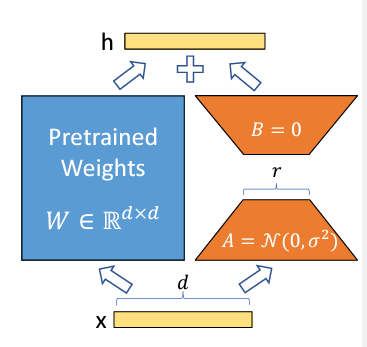

In [21]:
class LoraLinear(nn.Module):
    """Lora Adapter for parameter efficient training
    decomposes nn.linear into 2 low rank weightes and combines the output of both nn.Linear and two low rank layer output
    """

    def __init__(
        self,
        linear_layer,
        rank: Optional[int] = 32,
        alpha: Optional[int] = 1,
        lora_dropout=0.0,
    ):
        super().__init__()

        self.linear = linear_layer

        self.in_features = self.linear.in_features
        self.out_features = self.linear.out_features
        self.rank = rank
        self.alpha = alpha

        std_dev = 1 / torch.sqrt(torch.tensor(self.rank).float())

        self.lora_a = nn.Parameter(
            torch.randn(
                self.rank,
                self.in_features,
            )
            * std_dev
        )
        self.lora_b = nn.Parameter(
            torch.zeros(self.out_features, self.rank)
        )  # reverse  order due to F.linear as it process xA^T
        self.dropout = nn.Dropout(lora_dropout)

    def forward(self, x):

        linear_output = self.linear(x)
        lora_output = self.alpha * F.linear(F.linear(x, self.lora_a), self.lora_b)
        lora_output = self.dropout(lora_output)
        return linear_output + lora_output

In [22]:
rank = 32
alpha = 1

for param in model_student.parameters():
    param.requires_grad = False

In [23]:
# trainable weights
sum(p.numel() for p in model_student.parameters() if p.requires_grad)

0

In [24]:
add_lora_layer = partial(LoraLinear, rank=rank, alpha=alpha)

In [25]:
for layer in model_student.encoder.layer:
    print(layer.attention.self)
    print(layer.attention.output)
    print(layer.intermediate)
    print(layer.output)
    break

RobertaSelfAttention(
  (query): Linear(in_features=768, out_features=768, bias=True)
  (key): Linear(in_features=768, out_features=768, bias=True)
  (value): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
RobertaSelfOutput(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
RobertaIntermediate(
  (dense): Linear(in_features=768, out_features=3072, bias=True)
  (intermediate_act_fn): GELUActivation()
)
RobertaOutput(
  (dense): Linear(in_features=3072, out_features=768, bias=True)
  (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [26]:
enable_lora_query = True
enable_lora_key = False
enable_lora_value = True
enable_lora_out = True
enable_lora_mlp = True
for layer in model_student.encoder.layer:
    if enable_lora_query:
        layer.attention.self.query = add_lora_layer(layer.attention.self.query)

    if enable_lora_key:
        layer.attention.self.key = add_lora_layer(layer.attention.self.key)

    if enable_lora_value:
        layer.attention.self.value = add_lora_layer(layer.attention.self.value)

    if enable_lora_out:
        layer.attention.output.dense = add_lora_layer(layer.attention.output.dense)

    if enable_lora_mlp:
        layer.intermediate.dense = add_lora_layer(layer.intermediate.dense)
        layer.output.dense = add_lora_layer(layer.output.dense)

In [27]:
# trainable weights
sum(p.numel() for p in model_student.parameters() if p.requires_grad)

2359296

In [28]:
class ClinicModel(nn.Module):
    def __init__(self, model_student):
        super().__init__()
        self.model = model_student
        self.output = nn.Linear(768, n_classes)

    def forward(self, ids, mask):
        sequence_output = self.model(ids, mask).last_hidden_state[:, 0, :]
        logits = self.output(sequence_output)
        return logits

In [29]:
net = ClinicModel(model_student)


def train(net, name="lora_adapter"):
    use_amp = True
    debug = False
    gc.collect()
    best_epoch_loss = np.inf
    net.cuda()
    log_df = pd.DataFrame(
        columns=["Epoch", "Train_Loss", "Valid_Loss", "Valid_Accuracy"]
    )
    accelerator = Accelerator(
        log_with="tensorboard", project_dir=".", mixed_precision="fp16"
    )
    Config = {"num_epoch": EPOCHS, "learning_rate": lr}

    accelerator.init_trackers(f"{name}_project", config=Config)

    loss_fn = torch.nn.CrossEntropyLoss()
    no_decay = ["bias", "LayerNorm.weight", "LayerNorm.bias"]
    optimizer_grouped_parameters = [
        {
            "params": [
                p
                for n, p in net.named_parameters()
                if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.01,
        },
        {
            "params": [
                p for n, p in net.named_parameters() if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=lr)
    num_train_optimization_steps = int(EPOCHS * len(train_loader) / accumulation_steps)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0.05 * num_train_optimization_steps,
        num_training_steps=num_train_optimization_steps,
    )  # PyTorch schedule
    epoch_check = len(train_loader)
    total_step = epoch_check * EPOCHS
    train_bar = tqdm(total=total_step, dynamic_ncols=True)
    val_bar = tqdm(total=len(val_loader), leave=True, dynamic_ncols=True)
    t_step = 1
    for epoch in range(EPOCHS):
        start_time = time.time()
        avg_loss = 0.0
        net.train()
        loss_list = []
        for step, data in enumerate(train_loader):
            train_bar.update(1)
            #         train_bar.set_description(f"step: {i+1} epoch: {epoch+1}")
            input_ids = data["ids"].cuda()
            input_masks = data["mask"].cuda()
            targets = data["labels"].long().view(-1).cuda()
            optimizer.zero_grad()
            pred = net(input_ids, input_masks)
            loss = loss_fn(pred, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            train_bar.set_description(
                f'epoch: {epoch+1} step: {t_step} loss: {"%.4f" % loss}'
            )
            accelerator.log({"training_loss_step": loss}, step=t_step)
            t_step += 1

        loss_list.append(loss.detach().cpu().item())

        avg_loss = np.round(np.mean(loss_list), 4)
        vloss, vaccuracy = valid_func(net, val_loader, val_bar)
        accelerator.log({"vloss_epoch": vloss}, step=epoch)
        accelerator.log({"vaccuracy_epoch": vaccuracy}, step=epoch)
        print(f'Epoc: {epoch} loss: {"%.4f" % vloss},accuracy: {"%.4f" % vaccuracy}')
        val_bar.reset()
    accelerator.end_training()


train(net)

2024-05-14 11:02:01.195213: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 11:02:01.195350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 11:02:01.326750: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


  0%|          | 0/717 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoc: 0 loss: 0.8316,accuracy: 0.8268
Epoc: 1 loss: 0.4754,accuracy: 0.9029
Epoc: 2 loss: 0.4195,accuracy: 0.9110


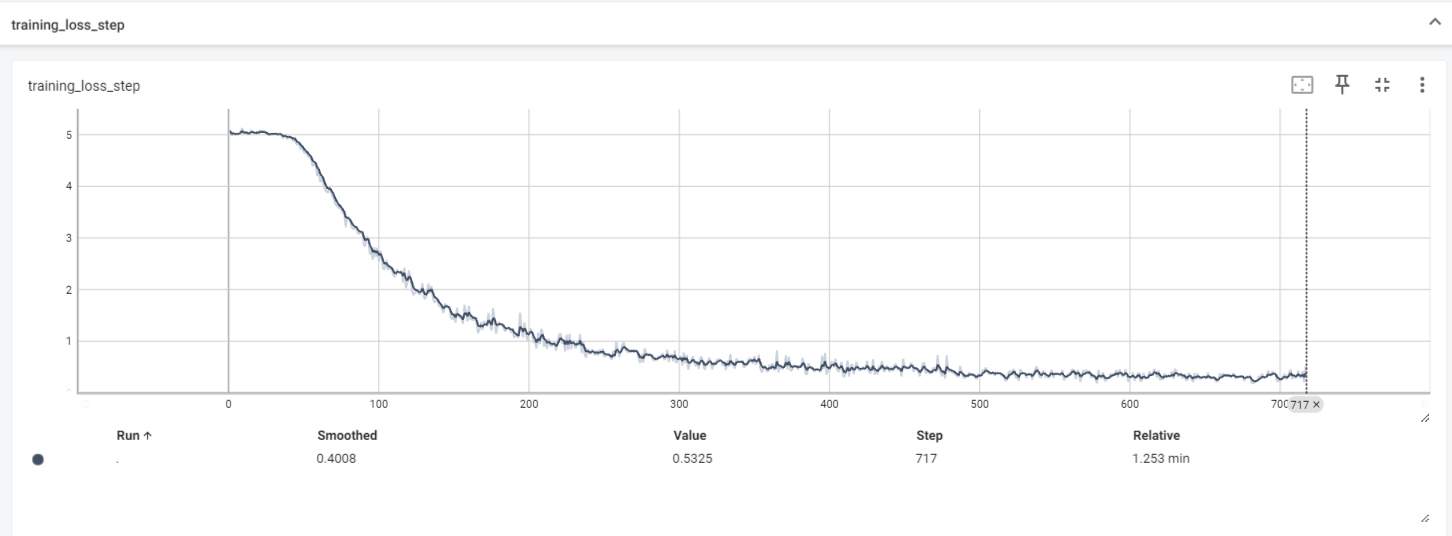

In [30]:
model_student = AutoModel.from_config(config=config)

In [31]:
model_student.load_state_dict(torch.load("../working/model_student.pth"))

<All keys matched successfully>

In [32]:
for param in model_student.parameters():
    param.requires_grad = False
sum(p.numel() for p in model_student.parameters() if p.requires_grad)

0

**Image from DORA Paper**

[Dora Paper](https://arxiv.org/abs/2402.09353)

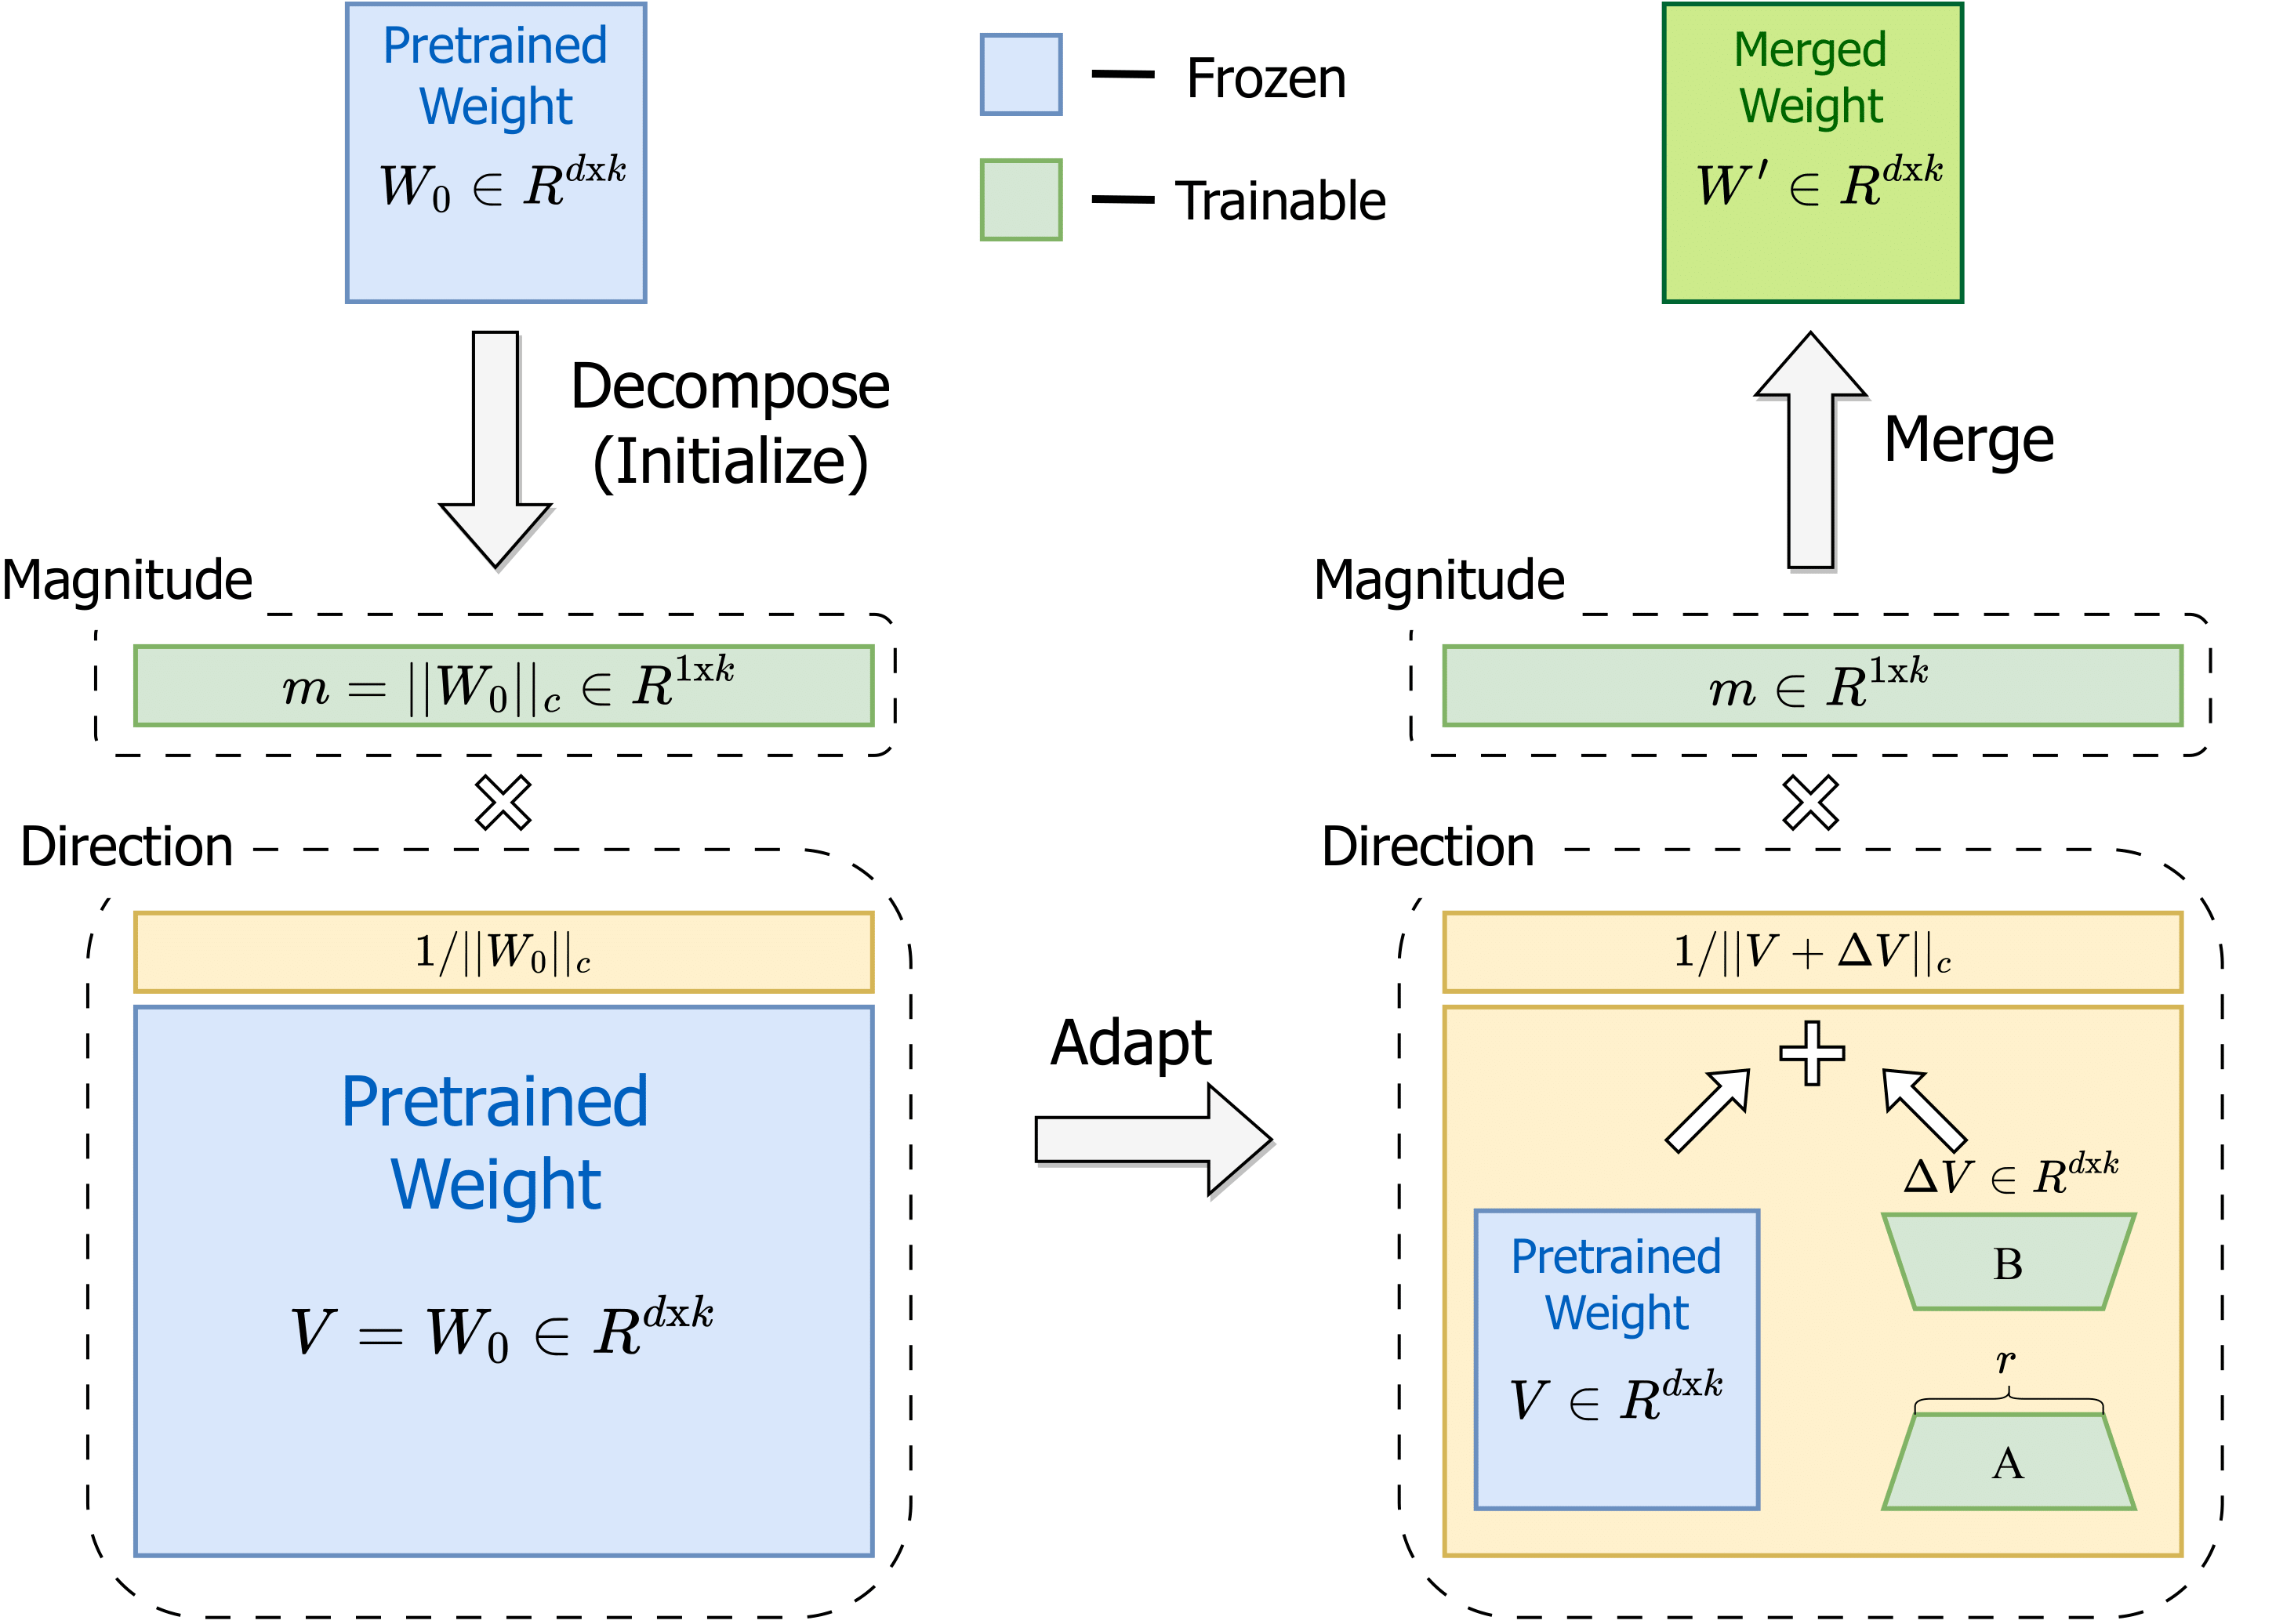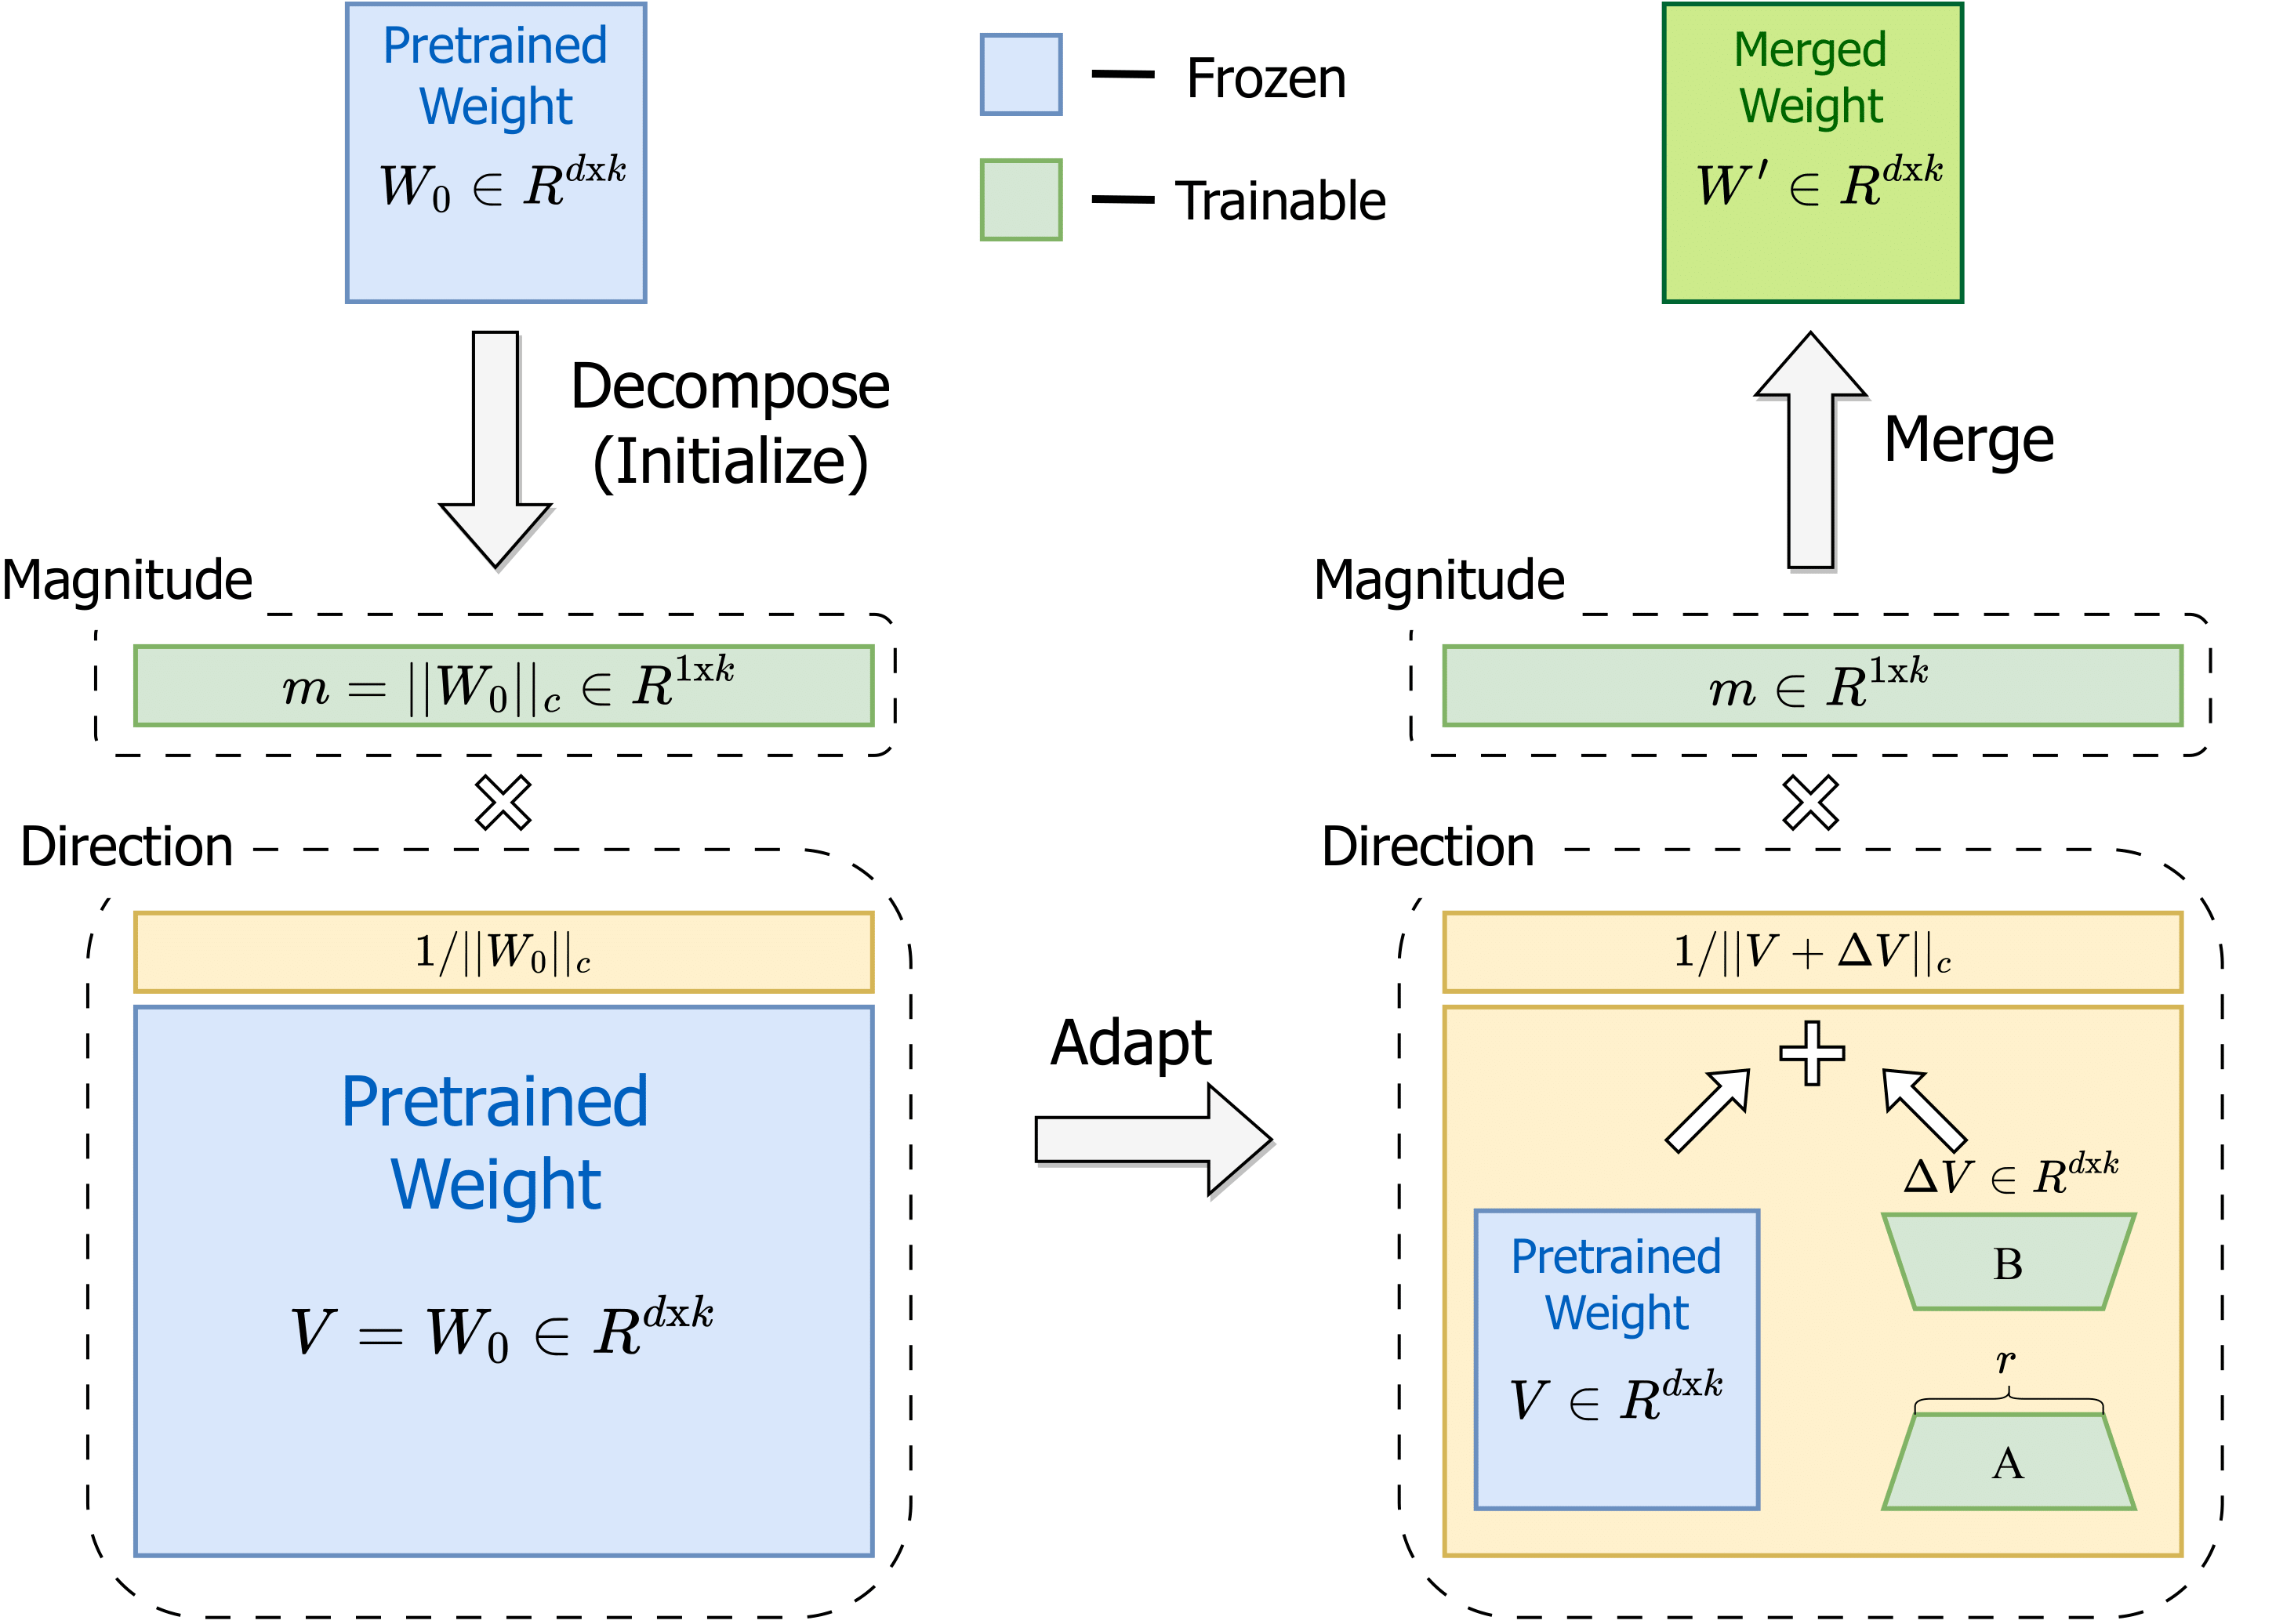

In [33]:
class DoraLinear(nn.Module):
    def __init__(self, linear_layer, rank=32):
        super().__init__()

        self.linear = linear_layer

        self.in_features = self.linear.in_features
        self.out_features = self.linear.out_features
        self.dora_m = nn.Parameter(self.linear.weight.norm(p=2, dim=0, keepdim=True))

        std_dev = 1 / torch.sqrt(torch.tensor(rank).float())
        self.dora_a = nn.Parameter(torch.randn(self.out_features, rank) * std_dev)
        self.dora_b = nn.Parameter(torch.zeros(rank, self.in_features))

    def forward(self, x):
        lora = torch.matmul(self.dora_a, self.dora_b)
        adapted = self.linear.weight + lora
        column_norm = adapted.norm(p=2, dim=0, keepdim=True)
        norm_adapted = adapted / column_norm
        calc_weights = self.dora_m * norm_adapted
        bias = getattr(self.linear, "bias", None)
        return F.linear(x, calc_weights, bias)

In [34]:
enable_dora_query = True
enable_dora_key = False
enable_dora_value = True
enable_dora_out = True
enable_dora_mlp = True
rank = 32
add_dora_layer = partial(DoraLinear, rank=rank)

In [35]:
for layer in model_student.encoder.layer:
    if enable_dora_query:
        layer.attention.self.query = add_dora_layer(layer.attention.self.query)

    if enable_dora_key:
        layer.attention.self.key = add_dora_layer(layer.attention.self.key)

    if enable_dora_value:
        layer.attention.self.value = add_dora_layer(layer.attention.self.value)

    if enable_dora_out:
        layer.attention.output.dense = add_dora_layer(layer.attention.output.dense)

    if enable_dora_mlp:
        layer.intermediate.dense = add_dora_layer(layer.intermediate.dense)
        layer.output.dense = add_dora_layer(layer.output.dense)

In [36]:
sum(p.numel() for p in model_student.parameters() if p.requires_grad)

2396160

In [37]:
net = ClinicModel(model_student)
train(net, name="dora_adapter")

  0%|          | 0/717 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoc: 0 loss: 1.0862,accuracy: 0.8042
Epoc: 1 loss: 0.5748,accuracy: 0.8823
Epoc: 2 loss: 0.4779,accuracy: 0.8987


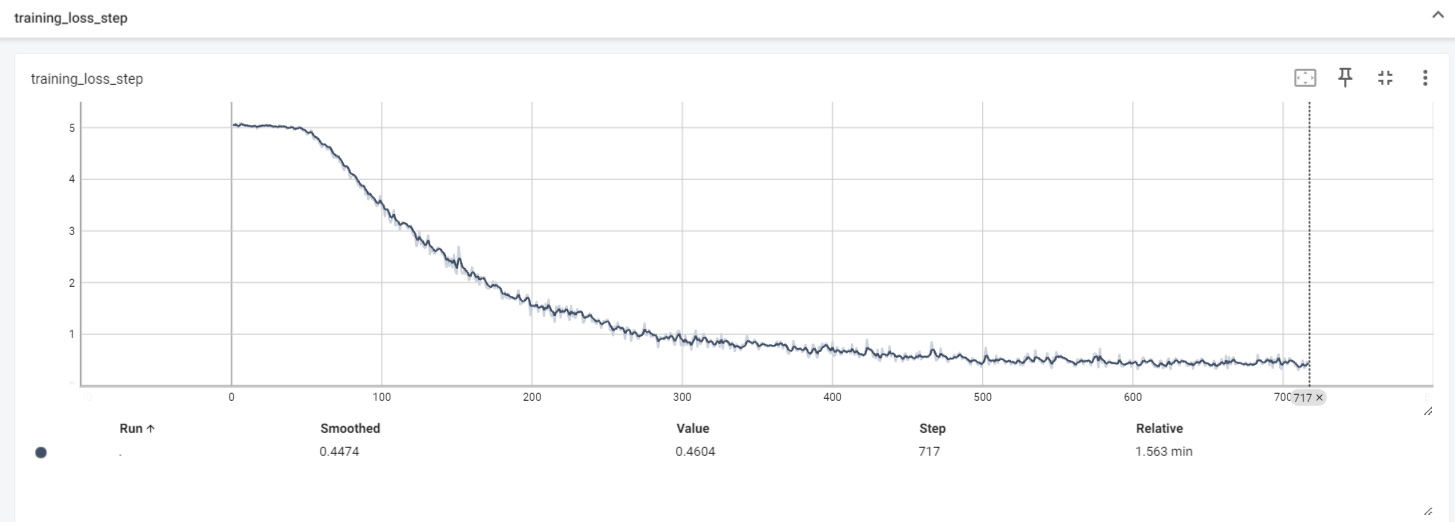